In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets

In [2]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt')))
type_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(type_dropdown)

Dropdown(description='source: ', index=1, options=('test', 'train'), value='train')

In [3]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt', type_dropdown.value)))
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='folder: ',
)
display(folder_dropdown)

Dropdown(description='folder: ', index=3, options=('1039-2088DA037-3', '1039-2088DA037-4', '1039-2088DA039-3', '1039-2088DA039-4'), value='1039-2088DA039-4')

In [9]:
annotation_folder = os.path.join(raw_folder,'second attempt', type_dropdown.value, folder_dropdown.value)
print(annotation_folder)
print(os.path.isdir(annotation_folder))
tifs = sorted(glob.glob( annotation_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

/media/deepinfer/mehrtash2/qanat/raw/second attempt/train/1039-2088DA037-3
True
no of tifs: 1


In [10]:
image_index = 0
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [11]:
labels = sorted(glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))

no of labels: 2


In [12]:
label_index = 0
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [13]:
print(label_path)
roi_path = label_path.replace('.nrrd', '_roi.acsv')

/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_1.nrrd


In [14]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [15]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[6581 5227] [8585 7231]


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'red'])

In [155]:
nda.shape
#nda[start[1]:end[1], start[0]:end[0]].shape

(7796, 18625)

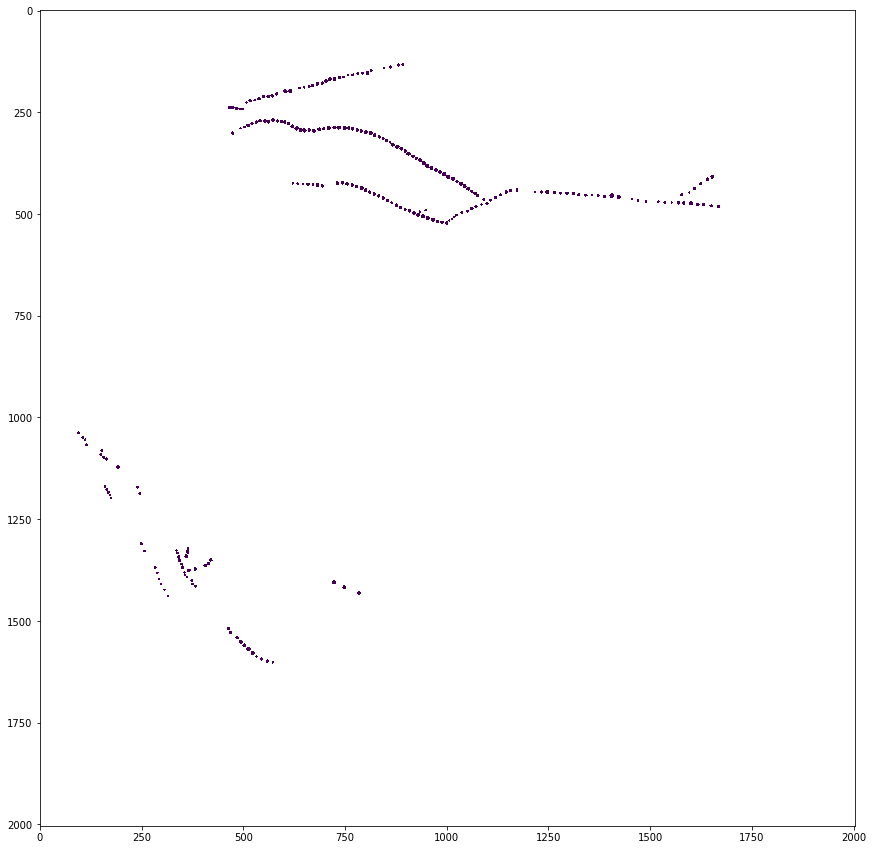

In [156]:
#
plt.figure(figsize=(15,15))
nda_mask1 = nda[start[1]:end[1], start[0]:end[0]]
label_mask1 = label_mask[start[1]:end[1], start[0]:end[0]]
plt.imshow(label_mask1)

In [157]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [169]:
hough_radii = np.arange(1, 2, 1)
hough_res = hough_circle(label_mask1, hough_radii)
# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1000)

In [170]:
label_circles = np.zeros(label_mask1.shape)
print(np.sum(label_circles))

0.0


In [171]:
for center_y, center_x, radius in zip(cy, cx, radii):
    #label_circles[center_y-1:center_y, center_x-1:center_x] = 1
    circy, circx = circle_perimeter(center_y, center_x, radius)
    label_circles[circy, circx] = 1

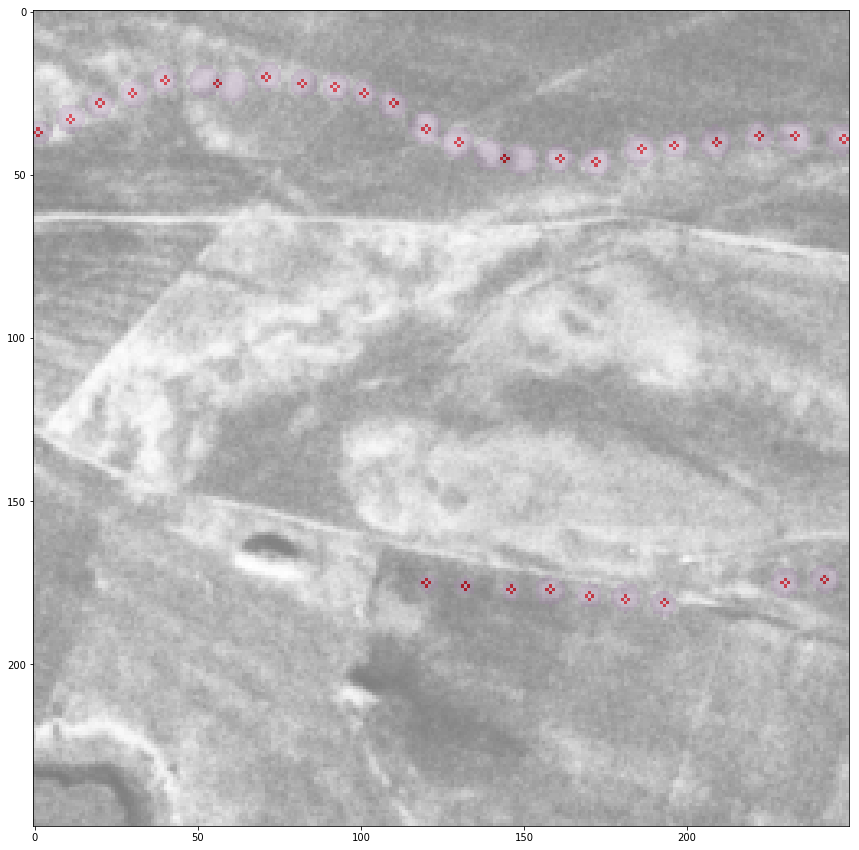

In [172]:
plt.figure(figsize=(15,15))
plt.imshow(nda_mask1[250:500, 500:750],alpha=1, cmap=plt.cm.gray)
plt.imshow(label_mask1[250:500, 500:750],alpha=0.3)
plt.imshow(label_circles[250:500, 500:750],alpha=0.5, cmap=cmap)

(array([4001077,       0,       0,       0,       0,       0,       0,
              0,       0,   14939]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))